# Pr√°ctica 2. Clustering de semillas

## 1. Visualizaci√≥n de datos con distintos scalers + PCA

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


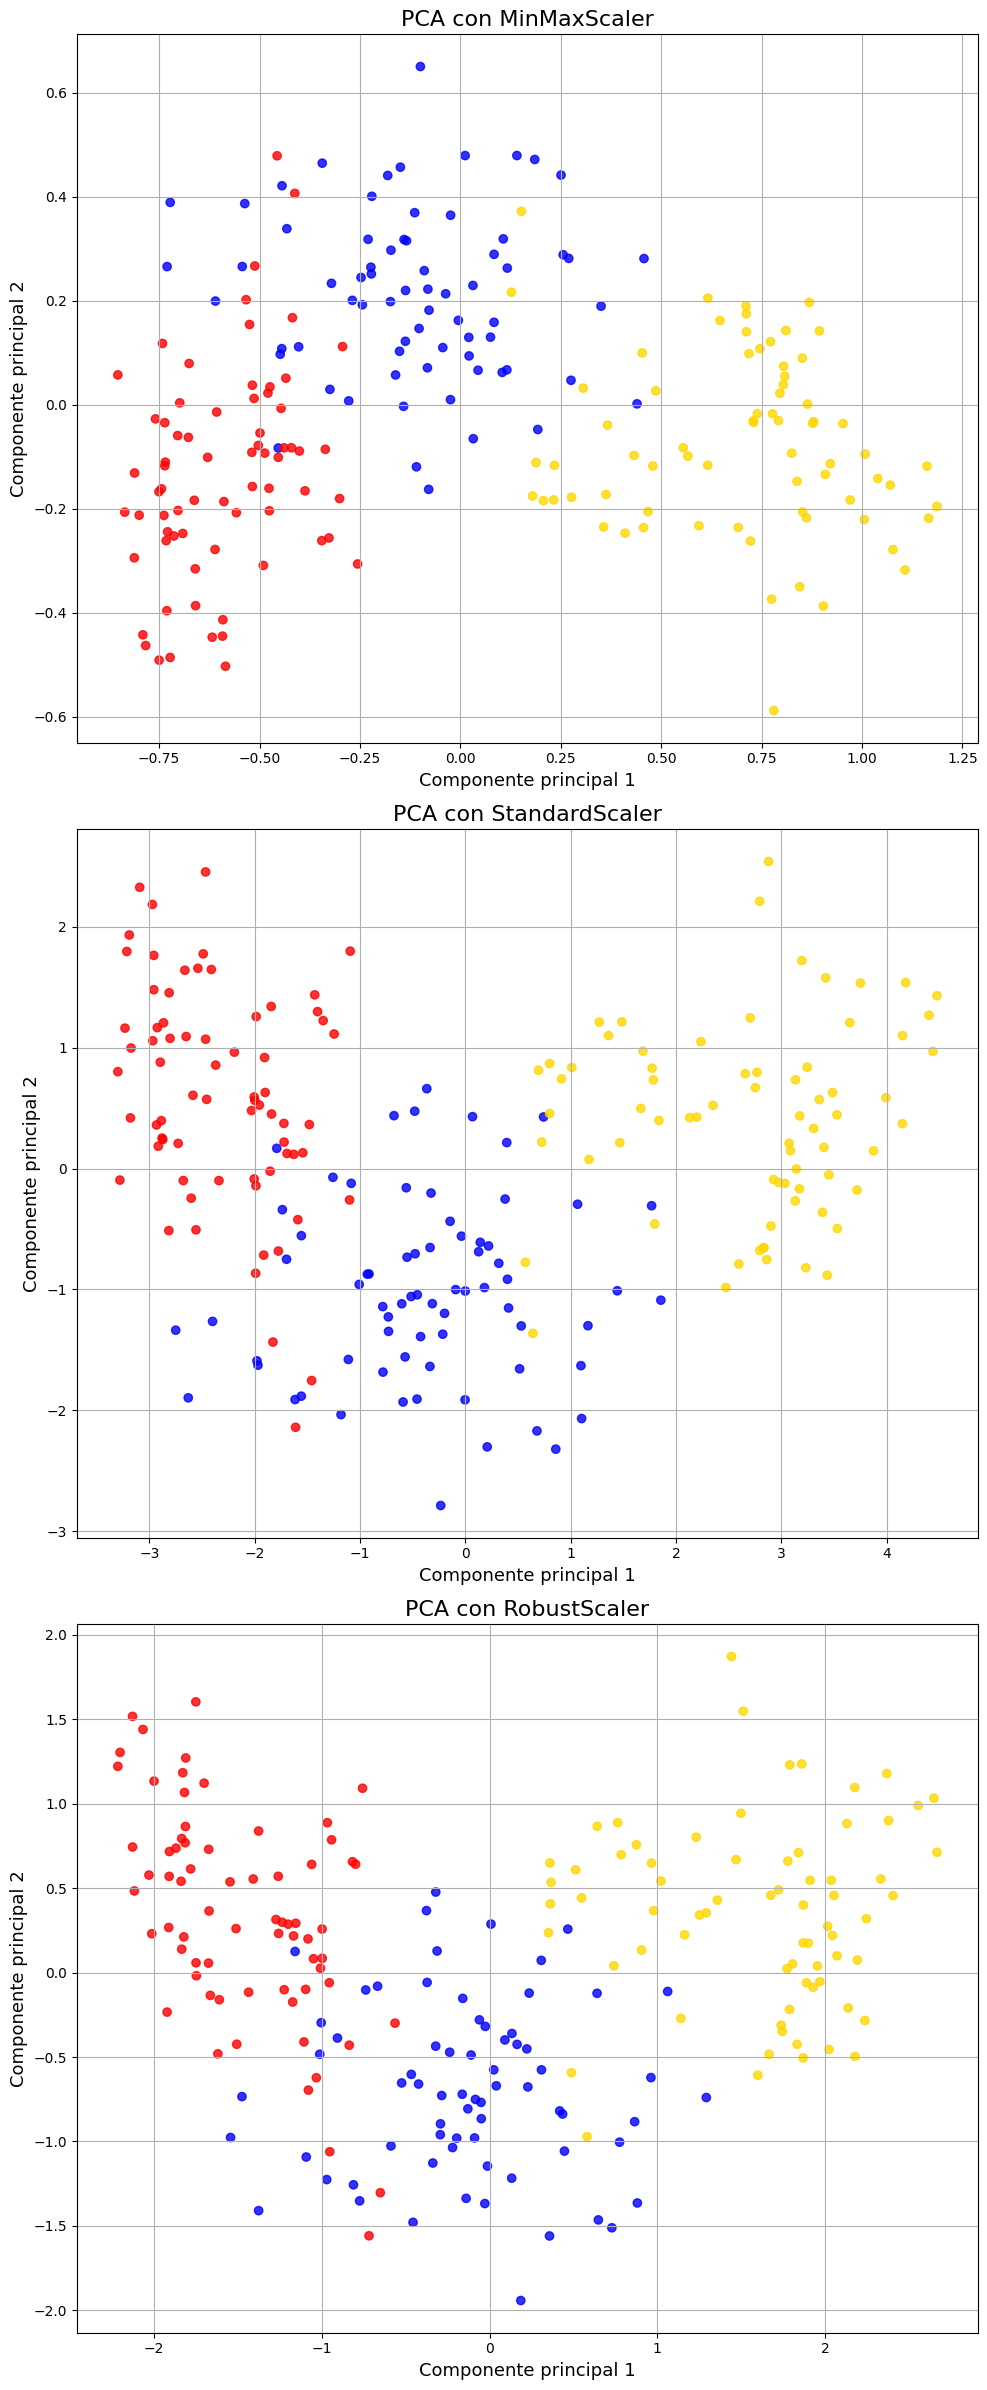

In [26]:
# Cargar datos
df = pd.read_csv("semillas.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Mapeo de colores personalizados por clase
color_map = {1: 'blue', 2: 'gold', 3: 'red'}
colors = y.map(color_map)

# Definir los escaladores
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

# Crear figura para mostrar los 3 gr√°ficos verticalmente
fig, axes = plt.subplots(3, 1, figsize=(10, 24))  # 10 de ancho, 24 de alto

for ax, (scaler_name, scaler) in zip(axes, scalers.items()):
    pipeline = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_pca = pipeline.fit_transform(X)

    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.8)
    ax.set_title(f"PCA con {scaler_name}", fontsize=16)
    ax.set_xlabel("Componente principal 1", fontsize=13)
    ax.set_ylabel("Componente principal 2", fontsize=13)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Comparativa de escaladores tras PCA 

Se ha aplicado PCA a los datos de semillas tras escalar con tres m√©todos distintos: **MinMaxScaler**, **StandardScaler** y **RobustScaler**. En cada caso se proyectan las instancias sobre los dos primeros componentes principales.

Los puntos est√°n coloreados seg√∫n la clase real de semilla:
- üîµ Clase 1
- üü° Clase 2
- üî¥ Clase 3

#### Observaciones:
- **MinMaxScaler** ofrece una separaci√≥n aceptable, especialmente entre las clases 2 (amarillo) y 3 (rojo), aunque con algo m√°s de solapamiento en el centro.
- **StandardScaler** proporciona una separaci√≥n **muy clara entre las tres clases**, con fronteras bastante definidas entre cada grupo. Las clases se distribuyen mejor en el plano de componentes.
- **RobustScaler** tambi√©n consigue una separaci√≥n razonable, aunque los grupos no se distinguen tanto como con StandardScaler. Aun as√≠, es robusto ante valores extremos.

#### Conclusi√≥n:
**StandardScaler** es el m√©todo de escalado que mejor preserva la estructura de clases del conjunto de datos original, facilitando una posible tarea de clustering. Por ello, se utilizar√° como preprocesamiento base en los siguientes apartados.


## 2. T√©cnicas de Clustering
Usamos X_2d aplicar los algoritmos de clustering: KMeans, jer√°rquico y DBSCAN, y visualizar los resultados de los clusters en un gr√°fico bidimensional

In [27]:
# Separar caracter√≠sticas (sin la clase)
X = df.iloc[:, :-1]

# Aplicar escalado y reducci√≥n a 2 dimensiones
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

### M√©todo del codo y silhoutte (KMeans)

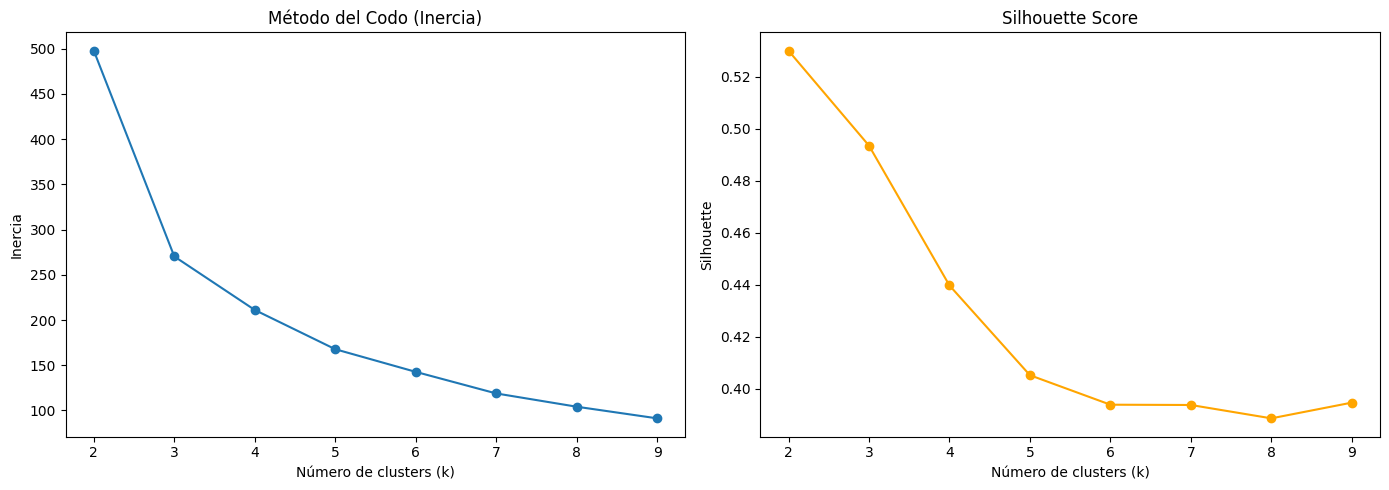

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
    kmeans.fit(X_2d)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_2d, kmeans.labels_))

# Gr√°ficos de evaluaci√≥n
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
ax[0].plot(K_range, inertia, marker='o')
ax[0].set_title("M√©todo del Codo (Inercia)")
ax[0].set_xlabel("N√∫mero de clusters (k)")
ax[0].set_ylabel("Inercia")

# Silhouette
ax[1].plot(K_range, silhouette, marker='o', color='orange')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("N√∫mero de clusters (k)")
ax[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()

- **M√©todo del Codo**: La inercia decrece al aumentar k, pero el cambio m√°s significativo parece estar en k = 3, lo cual sugiere que podr√≠a ser un buen n√∫mero de clusters.

-  **Silhouette Score**: El valor tambi√©n es m√°s alto para k = 3, lo que confirma que 3 es una buena elecci√≥n, ya que indica mejor separaci√≥n entre clusters.

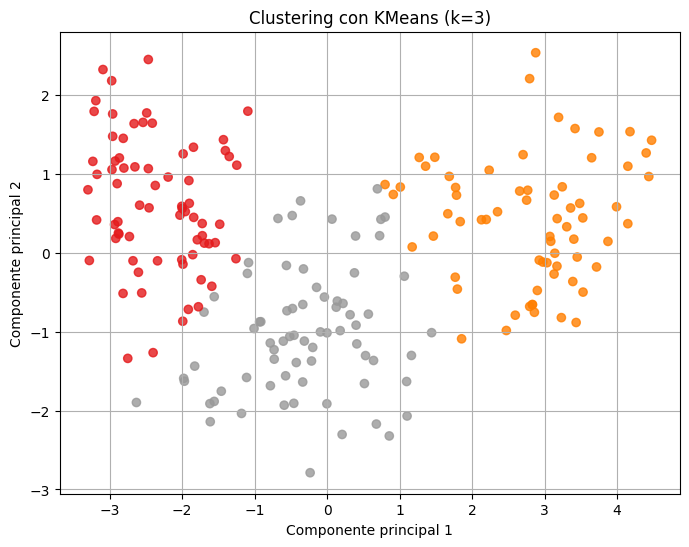

In [29]:
# Aplicar KMeans con k=3
kmeans_final = KMeans(n_clusters=3, n_init=25, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_2d)

# Visualizar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, cmap="Set1", alpha=0.8)
plt.title("Clustering con KMeans (k=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

## M√©todo Hierarchical Clustering / Dendrogramas

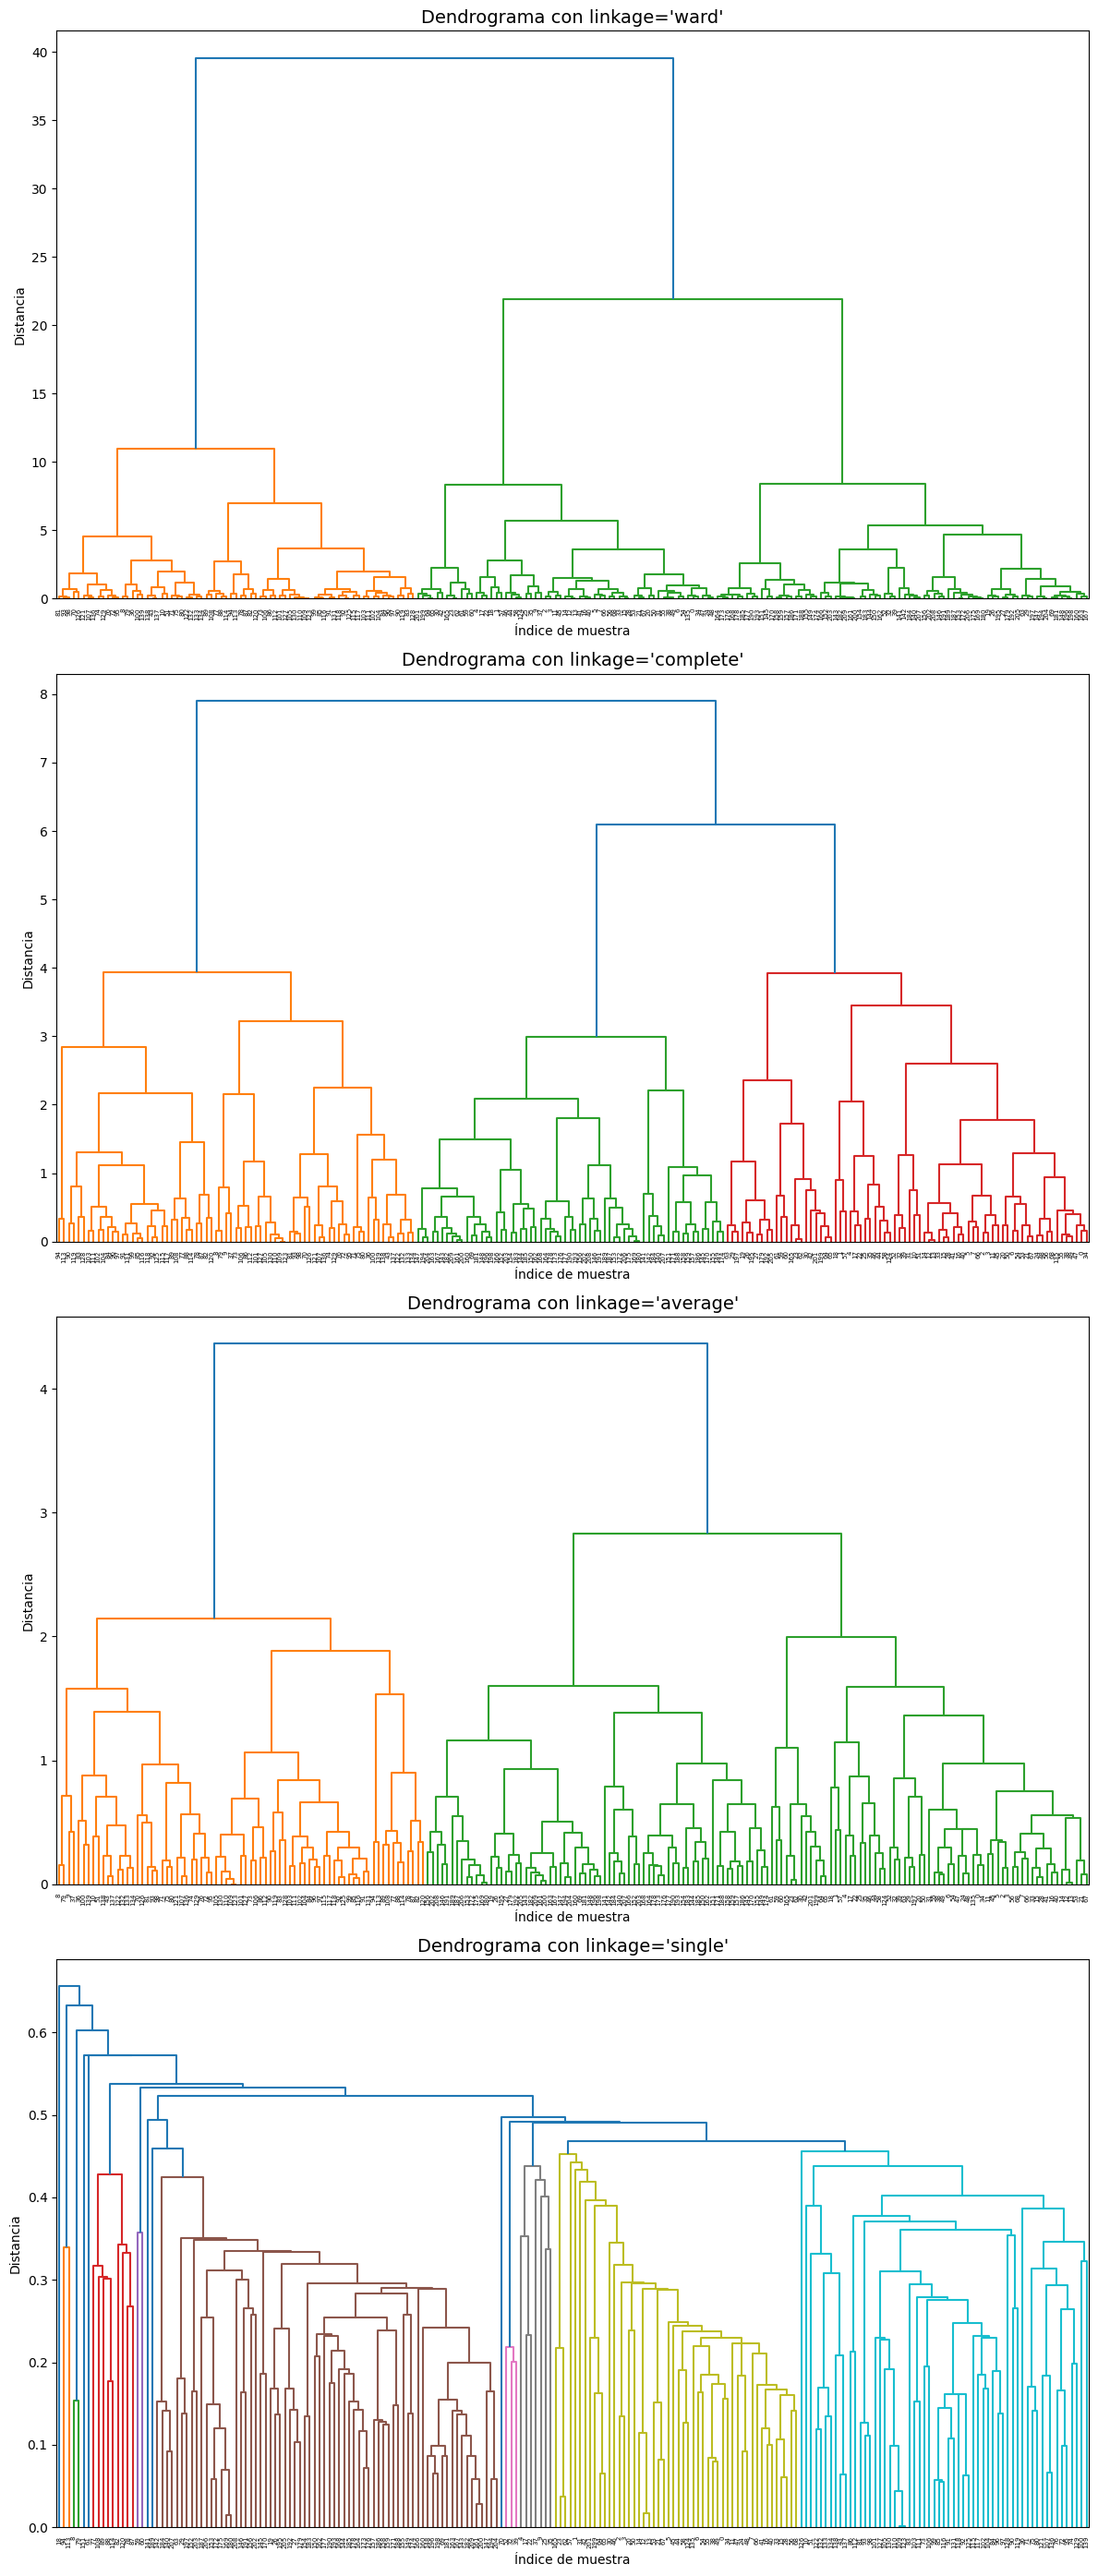

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# M√©todos de linkage a probar
linkage_methods = ["ward", "complete", "average", "single"]

# Dibujar un dendrograma para cada tipo de linkage
fig, axes = plt.subplots(len(linkage_methods), 1, figsize=(12, 28))

for ax, method in zip(axes, linkage_methods):
    Z = linkage(X_2d, method=method)
    dendrogram(Z, ax=ax)
    ax.set_title(f"Dendrograma con linkage='{method}'", fontsize=14)
    ax.set_xlabel("√çndice de muestra")
    ax.set_ylabel("Distancia")

plt.tight_layout()
plt.show()

**ward**: muestra una separaci√≥n muy clara en 3 grandes bloques, ideal para este problema. Es el m√°s recomendado si trabajas con distancias eucl√≠deas.

**complete** y **average**: tambi√©n muestran una separaci√≥n en 3 o 4 grupos razonables.

**single**: crea una estructura m√°s encadenada (efecto cadena), lo que suele generar malos resultados en clustering ‚Äî no es recomendable en este caso.

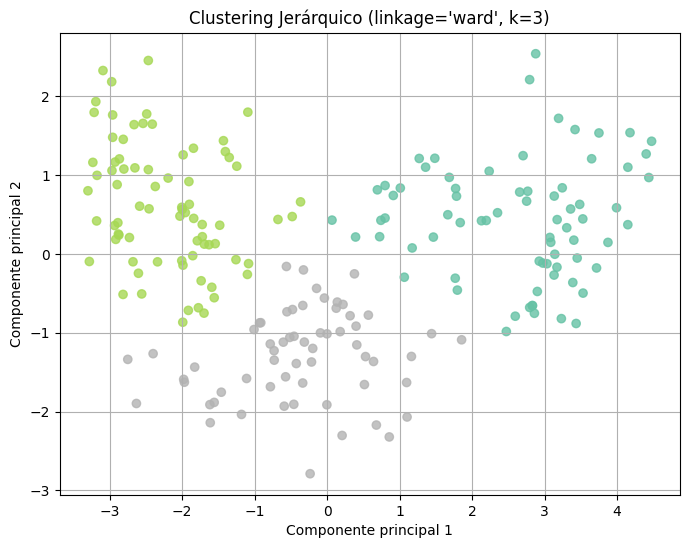

In [31]:
from sklearn.cluster import AgglomerativeClustering

# Aplicar clustering jer√°rquico con linkage 'ward' y 3 clusters
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agglo = agglo.fit_predict(X_2d)

# Visualizar los clusters jer√°rquicos
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_agglo, cmap="Set2", alpha=0.8)
plt.title("Clustering Jer√°rquico (linkage='ward', k=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


Este resultado del clustering jer√°rquico con ward y k=3 se ve muy limpio y estructurado:

    Los tres grupos est√°n bien separados visualmente.

    No parece haber solapamientos importantes entre los clusters.

    Es un gran punto de comparaci√≥n contra KMeans.

## M√©todo DBSCAN

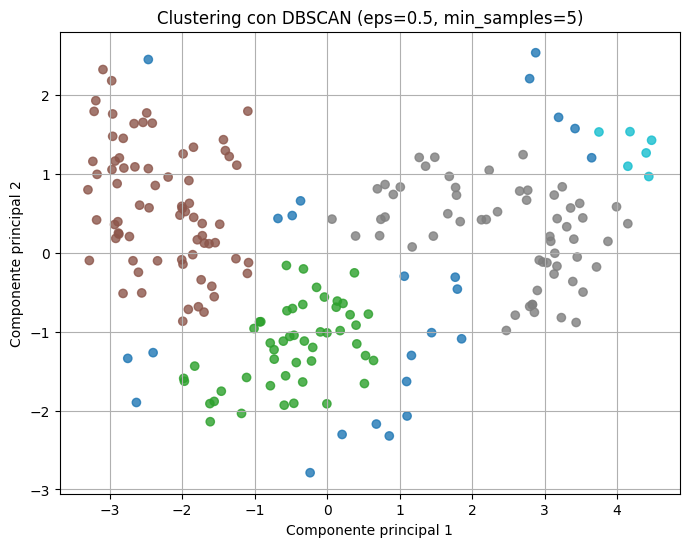

In [32]:
from sklearn.cluster import DBSCAN

# Aplicar DBSCAN con valores iniciales
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_2d)

# Visualizar el resultado de DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
plt.title("Clustering con DBSCAN (eps=0.5, min_samples=5)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


DBSCAN ha identificado m√°s de 3 clusters, y probablemente algunos puntos como ruido (label = -1), que aparecen con un color distinto o m√°s tenue.
Algunos grupos est√°n razonablemente bien formados, pero otros parecen fragmentados, lo que sugiere que los valores por defecto podr√≠an no ser ideales.

Toca ajustar los hiperpar√°metros:
- eps (radio de vecindad): prueba valores entre 0.3 y 0.8.

- min_samples (m√≠nimo de vecinos para formar un n√∫cleo): normalmente entre 3 y 10.

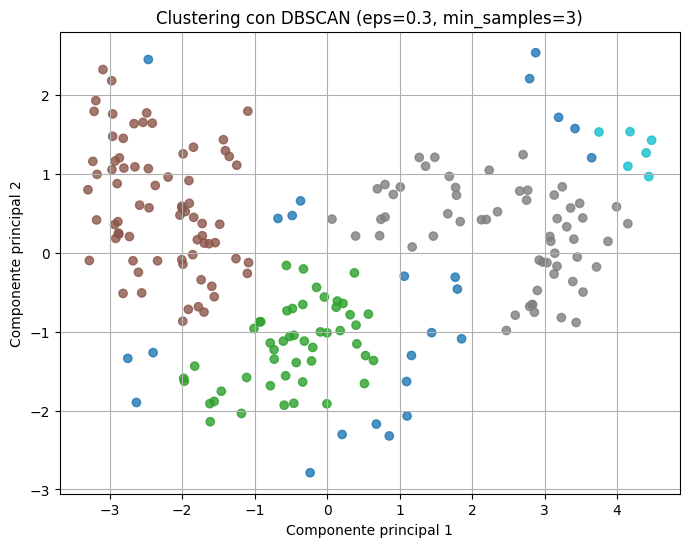

In [33]:
# Aplicar DBSCAN con valores iniciales
dbscan_min = DBSCAN(eps=0.3, min_samples=3)
labels_dbscan_min = dbscan_min.fit_predict(X_2d)

# Visualizar el resultado de DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
plt.title("Clustering con DBSCAN (eps=0.3, min_samples=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

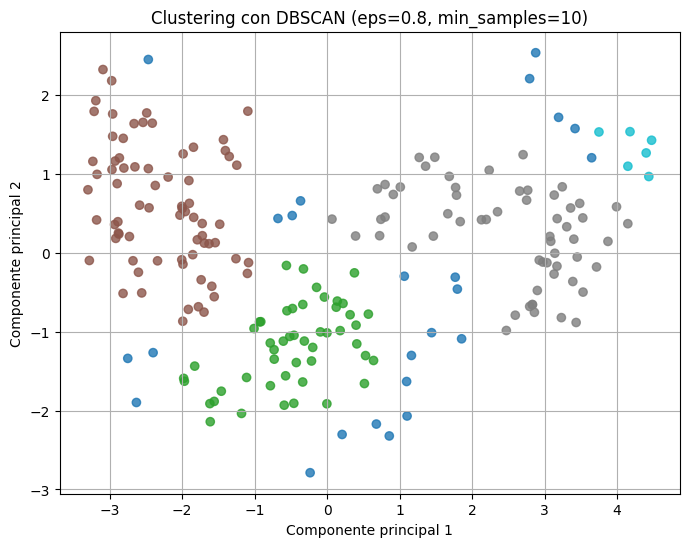

In [34]:
# Aplicar DBSCAN con valores iniciales
dbscan_max = DBSCAN(eps=0.8, min_samples=10)
labels_dbscan_max = dbscan_max.fit_predict(X_2d)

# Visualizar el resultado de DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
plt.title("Clustering con DBSCAN (eps=0.8, min_samples=10)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

### Comparativa de DBSCAN con distintas configuraciones

Se ha probado el algoritmo DBSCAN variando los hiperpar√°metros `eps` (radio de vecindad) y `min_samples` (m√≠nimo de vecinos para formar un n√∫cleo). A continuaci√≥n se muestran los resultados:

#### üîπ DBSCAN (eps = 0.5, min_samples = 5)
- Se identifican **3 grupos principales** que coinciden razonablemente con la estructura esperada.
- Algunos puntos aparecen como **ruido**, pero no de forma excesiva.
- Es una **configuraci√≥n equilibrada**, capaz de captar la estructura sin sobresegmentar ni agrupar todo en uno solo.

#### üî∏ DBSCAN (eps = 0.3, min_samples = 3)
- Se generan **muchos clusters peque√±os**, lo cual indica **overclustering**.
- El algoritmo es muy sensible a peque√±as variaciones, y muchos puntos son detectados como grupos independientes.
- No resulta √∫til para interpretar una estructura global.

#### üî∏ DBSCAN (eps = 0.8, min_samples = 10)
- Se obtiene un n√∫mero elevado de clusters peque√±os, muy parecido al caso anterior.
- Esta combinaci√≥n parece **demasiado permisiva**, lo que lleva a fragmentar los datos.
- Se detectan tambi√©n muchos valores at√≠picos.

---

**‚úÖ Conclusi√≥n**: La combinaci√≥n **`eps = 0.5`, `min_samples = 5`** es la m√°s apropiada, ya que detecta 3 agrupaciones bien definidas y un n√∫mero moderado de outliers. Esta configuraci√≥n ser√° la utilizada en el an√°lisis final.


## 3. An√°lisis
###  ¬øCu√°l de los m√©todos de clustering captura mejor la estructura de clusters de este problema? 

Para realizar el an√°lisis vamos a rehacer el c√≥digo, asi evitamos una sobrecarga temporal del entorno, ya que el c√≥digo es correcto y ya lo he ejecutado con √©xito anteriormente.

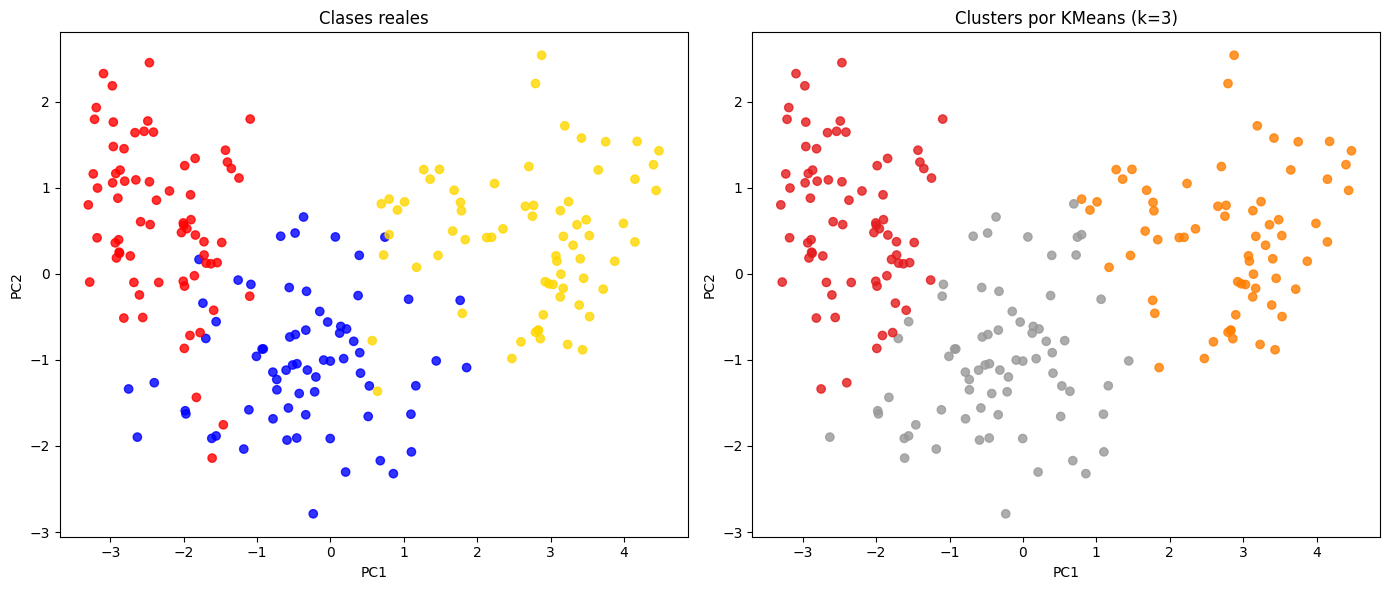

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Cargar datos
df = pd.read_csv("semillas.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]  # clase real

# Reducir a 2D con StandardScaler + PCA
X_scaled = StandardScaler().fit_transform(X)
X_2d = PCA(n_components=2).fit_transform(X_scaled)

# KMeans clustering
labels_kmeans = KMeans(n_clusters=3, n_init=25, random_state=42).fit_predict(X_2d)

# Mapa de colores para clase real
color_map = {1: 'blue', 2: 'gold', 3: 'red'}
colors = y.map(color_map)

# Visualizaci√≥n
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Clases reales
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.8)
ax[0].set_title("Clases reales")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Clusters por KMeans
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, cmap="Set1", alpha=0.8)
ax[1].set_title("Clusters por KMeans (k=3)")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


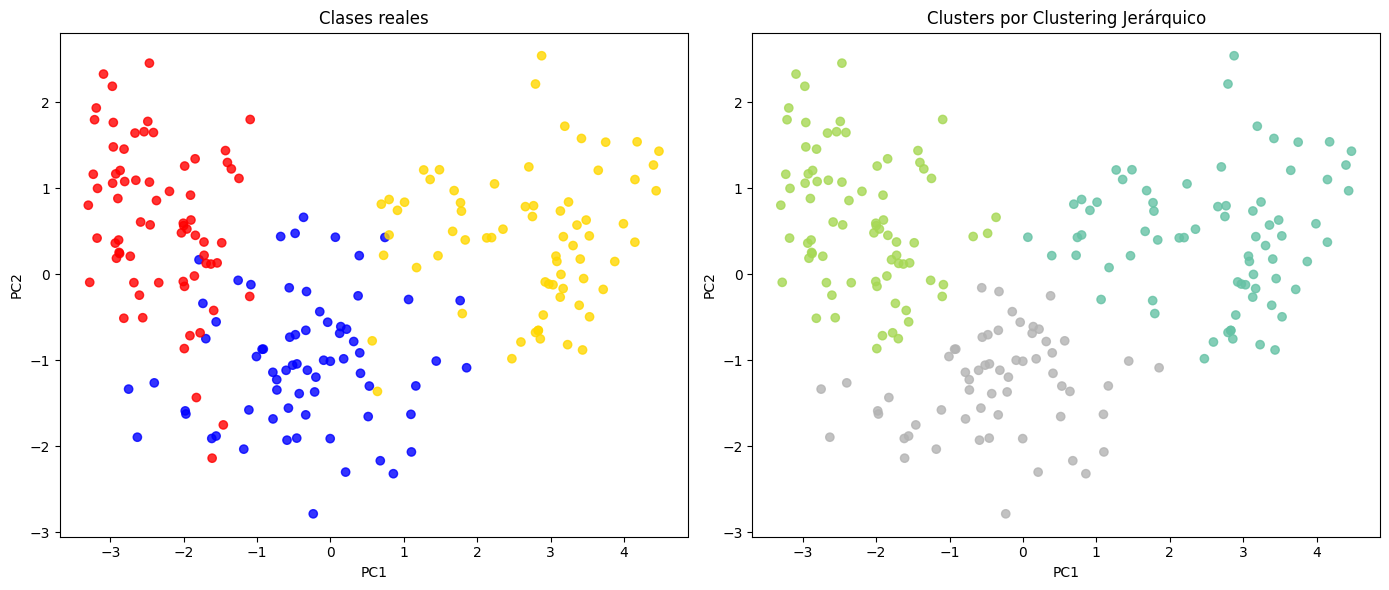

In [36]:
# Re-importar librer√≠as y recargar datos tras el reset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Cargar datos
df = pd.read_csv("semillas.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Escalado + PCA
X_scaled = StandardScaler().fit_transform(X)
X_2d = PCA(n_components=2).fit_transform(X_scaled)

# Colores por clase
color_map = {1: 'blue', 2: 'gold', 3: 'red'}
colors = y.map(color_map)

# Clustering jer√°rquico
labels_agglo = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X_2d)

# Visualizaci√≥n
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Clases reales
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.8)
ax[0].set_title("Clases reales")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Clusters por jer√°rquico
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_agglo, cmap="Set2", alpha=0.8)
ax[1].set_title("Clusters por Clustering Jer√°rquico")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


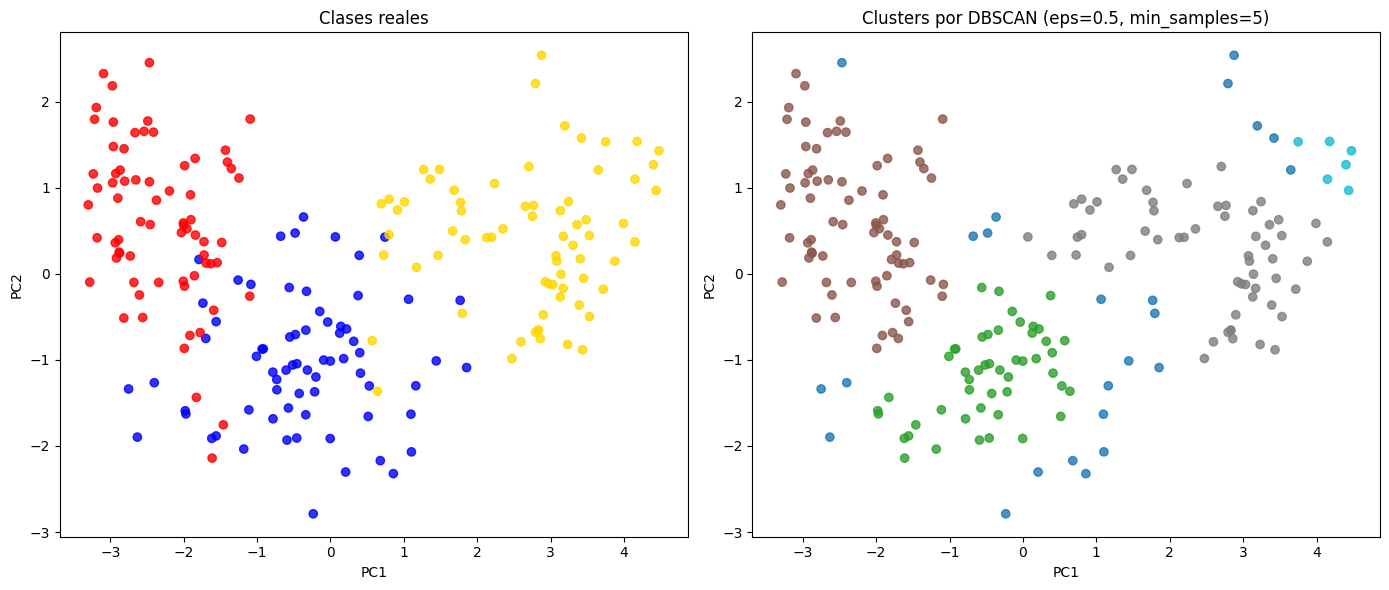

In [37]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Ejecutar DBSCAN con los par√°metros elegidos
labels_dbscan = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_2d)

# Visualizaci√≥n comparativa
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Clases reales
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.8)
ax[0].set_title("Clases reales")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Clusters por DBSCAN
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
ax[1].set_title("Clusters por DBSCAN (eps=0.5, min_samples=5)")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


### Comparaci√≥n visual entre clustering y clases reales

Se muestran a continuaci√≥n los resultados de los tres algoritmos de clustering aplicados a los datos reducidos con PCA (2 componentes), comparados con la distribuci√≥n original de las clases reales.

#### üîπ KMeans (`k=3`)
- Los grupos formados se corresponden **razonablemente bien con las clases reales**.
- La separaci√≥n entre clusters es clara, especialmente en los extremos.
- Algunos puntos se encuentran mal clasificados, pero el patr√≥n general es coherente.

#### üî∏ Clustering jer√°rquico (linkage = `ward`, `k=3`)
- **Resultado muy similar al de KMeans**, con fronteras bien definidas.
- Capta correctamente la estructura de los tres grupos principales.
- Ligero solapamiento en zonas intermedias, pero en general muy efectivo.

#### üî∏ DBSCAN (`eps = 0.5`, `min_samples = 5`)
- Identifica agrupaciones relevantes, pero **no se alinea tan bien con las clases reales**.
- Algunos puntos son marcados como **ruido (`-1`)**, lo que puede ser √∫til para detectar outliers.
- Es m√°s sensible a la densidad de los datos que los m√©todos anteriores.

---

**‚úÖ Conclusi√≥n visual**:  
Tanto **KMeans como el clustering jer√°rquico** ofrecen una buena aproximaci√≥n a la distribuci√≥n real de las clases. DBSCAN aporta valor al detectar puntos at√≠picos, pero no reproduce con tanta fidelidad la estructura de clases original.


### ¬øHay relaci√≥n entre los clusters obtenidos y las clases de semillas originales? (variable de respuesta ‚Äúclase‚Äù)
Para contestar esta pregunta, a parte de explicar visualmente si los clusters y las clases coinciden (Lo hice anteriormente) Tenemos que calcular una m√©trica de similitud entre etiquetas

In [38]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import pandas as pd

# Clustering
labels_kmeans = KMeans(n_clusters=3, n_init=25, random_state=42).fit_predict(X_2d)
labels_agglo = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X_2d)
labels_dbscan = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_2d)

# Etiquetas reales
true_labels = df.iloc[:, -1]

# M√©tricas
ari_kmeans = adjusted_rand_score(true_labels, labels_kmeans)
ami_kmeans = adjusted_mutual_info_score(true_labels, labels_kmeans)

ari_agglo = adjusted_rand_score(true_labels, labels_agglo)
ami_agglo = adjusted_mutual_info_score(true_labels, labels_agglo)

ari_dbscan = adjusted_rand_score(true_labels, labels_dbscan)
ami_dbscan = adjusted_mutual_info_score(true_labels, labels_dbscan)

# Mostrar resultados en tabla
resultados = pd.DataFrame({
    "ARI": [ari_kmeans, ari_agglo, ari_dbscan],
    "AMI": [ami_kmeans, ami_agglo, ami_dbscan]
}, index=["KMeans", "Jer√°rquico", "DBSCAN"])

print(resultados)


                 ARI       AMI
KMeans      0.785036  0.736089
Jer√°rquico  0.753794  0.710466
DBSCAN      0.636568  0.605435


#### ‚úÖ Conclusi√≥n:
S√≠ existe una relaci√≥n significativa entre los clusters generados y las clases originales.  
Los mejores resultados se obtienen con **KMeans**, seguido de cerca por el m√©todo **jer√°rquico**.  
Ambos superan claramente a DBSCAN, que si bien captura estructura, no reproduce tan fielmente las clases reales.

### Boxplots

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# A√±adir etiquetas de cluster de KMeans
df_clusters = df.copy()
df_clusters["Cluster_KMeans"] = labels_kmeans

# Obtener las variables num√©ricas originales
features = df.columns[:-1]

# Crear figura
fig, axes = plt.subplots(len(features), 1, figsize=(10, 4 * len(features)))

# Graficar un boxplot por variable
for i, feature in enumerate(features):
    sns.boxplot(x="Cluster_KMeans", y=feature, data=df_clusters, ax=axes[i])
    axes[i].set_title(f"Distribuci√≥n de '{feature}' por cluster (KMeans)")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()



ModuleNotFoundError: No module named 'seaborn'

### Interpretaci√≥n de los clusters obtenidos con KMeans mediante boxplots

Para entender las caracter√≠sticas que definen cada grupo generado por KMeans, se han representado boxplots de las variables originales seg√∫n el cluster asignado.

#### üîç Principales observaciones:

- **√Årea y Per√≠metro**: los clusters muestran diferencias claras. Un grupo tiene valores de √°rea y per√≠metro notablemente mayores, lo que sugiere que esta dimensi√≥n es clave en la separaci√≥n.
  
- **Longitud del eje mayor y menor**: tambi√©n discriminan bien entre clusters. Los boxplots muestran c√≥mo un grupo tiene ejes significativamente m√°s largos.

- **Compacidad y simetr√≠a**: estas variables muestran una separaci√≥n m√°s sutil, pero siguen una tendencia que contribuye a la estructura de los grupos.

- **Longitud del surco**: es una de las variables m√°s √∫tiles para diferenciar los clusters, ya que presenta medianas claramente distintas en los tres grupos.

---

### ‚úÖ Conclusi√≥n:
Los clusters generados por KMeans no solo reflejan bien la estructura de clases, sino que adem√°s permiten identificar qu√© variables (como √°rea, per√≠metro, eje mayor y longitud del surco) son **m√°s relevantes para caracterizar los distintos tipos de semillas**.
